In [1]:
import torch
from torch import nn
from lib.mnist_aug import caption_rules
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [2]:
aug = MNISTAug()
aug.min_objects = 1
aug.max_objects = 1

In [3]:
dm = DataManager()
dm.load()

In [4]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 2000, get_positional_labels=True)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 20, get_positional_labels=True)

/Users/akhildevarashetti/code/ml_gallery/ml_py/venv/lib/python3.8/site-packages/skimage/transform/_warps.py:115: RuntimeWarning: divide by zero encountered in true_divide
  factors = (np.asarray(input_shape, dtype=float) /


cannot convert float infinity to integer
cannot convert float infinity to integer


In [5]:
x_train = torch.FloatTensor(x_train.reshape((-1, 1, 112, 112)))
x_test = torch.FloatTensor(x_test.reshape((-1, 1, 112, 112)))
x_train.shape

torch.Size([2000, 1, 112, 112])

center


/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:443: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


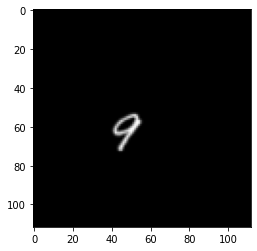

In [6]:
DataManager.plot_num(x_train[2].reshape((112, 112,)))
print(caption_rules.index_to_pos[y_train[2][0]['position']])

In [7]:
class PositionalEncoder2D(nn.Module):
    def __init__(self, c: int, h: int, w: int):
        super().__init__()
        self.w = (torch.rand((1, c, h, w)) - 0.5).requires_grad_()

    def forward(self, x):
        batch_size = x.shape[0]
        encoded = self.w.expand((batch_size, -1, -1, -1))
        return torch.cat((x, encoded), 1)

In [12]:
class PositionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.pos_enc = PositionalEncoder2D(2, 5, 5)
        self.positional_compression = nn.Sequential(
            nn.Conv2d(32 + 2, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(nn.Linear(32, 10), nn.Softmax())
        self.position_classifier = nn.Sequential(nn.Linear(32, 9), nn.Softmax())

    def forward(self, x):
        features = self.features(x)
        positional_features = self.pos_enc(features)
        compressed = self.positional_compression(positional_features)
        flattened = torch.flatten(compressed, 1)
        cls = self.classifier(flattened)
        pos = self.position_classifier(flattened)
        return cls, pos

In [13]:
model = PositionalClassifier()
optimizer = torch.optim.Adam(model.parameters())
position_loss = torch.nn.CrossEntropyLoss()

In [14]:
epochs = 15
batch_size = 100

for epoch in range(epochs):

    losses = 0
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size

        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        y_pos = torch.tensor([y[0]['position'] for y in y_batch])
        y_cls = torch.tensor([y[0]['class'] for y in y_batch])

        optimizer.zero_grad()

        cls, pos = model(x_batch)

        loss_pos = position_loss(pos, y_pos)
        loss_cls = position_loss(cls, y_cls)

        loss = 0 * loss_cls + 1 * loss_pos

        loss.backward()
        optimizer.step()

        losses += float(loss)

    print(f'{epoch=}, loss={float(losses)}')

/Users/akhildevarashetti/code/ml_gallery/ml_py/venv/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch=0, loss=43.81869649887085
epoch=1, loss=42.63250017166138
epoch=2, loss=40.176116704940796
epoch=3, loss=38.08800673484802
epoch=4, loss=37.357128977775574
epoch=5, loss=37.01226353645325
epoch=6, loss=36.99293541908264
epoch=7, loss=36.96124601364136
epoch=8, loss=37.03534281253815
epoch=9, loss=37.15006101131439
epoch=10, loss=36.81649100780487
epoch=11, loss=36.97252595424652
epoch=12, loss=36.81218504905701
epoch=13, loss=36.65887999534607
epoch=14, loss=36.5728063583374


bottom-right bottom-right
8 1
---
center top
3 0
---
bottom-right right
8 9
---
center center
3 4
---
center center
3 9
---
center top
3 2
---
center top
3 9
---
bottom-right bottom-right
8 8
---
bottom-right right
8 6
---
center top
3 0
---
right top-right
2 7
---
bottom-right bottom-right
8 7
---
bottom bottom
8 3
---
bottom-right left
3 9
---
center left
3 3
---
right right
3 1
---
center center
3 0
---
center center
3 2
---
center top-left
3 1
---
right right
2 6
---


/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:443: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


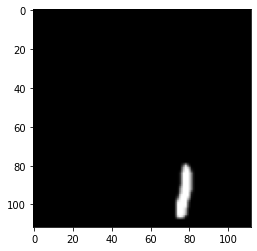

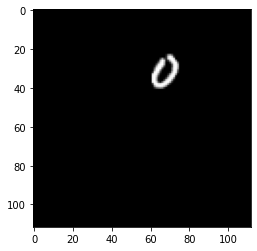

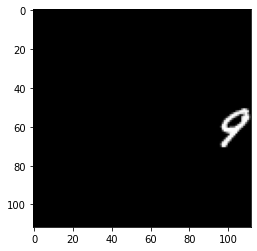

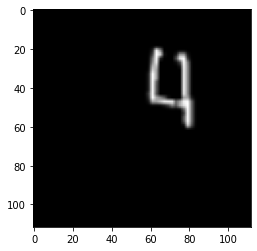

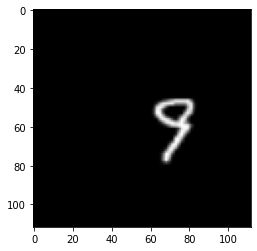

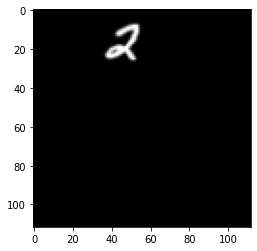

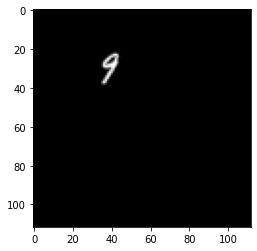

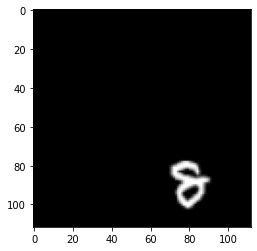

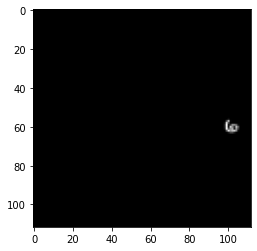

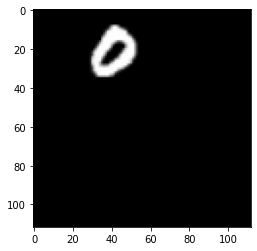

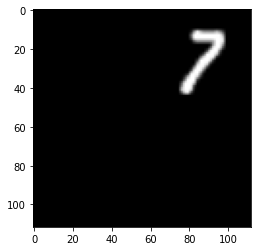

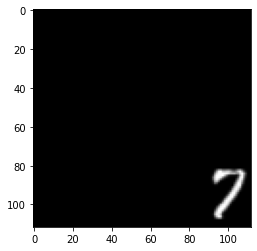

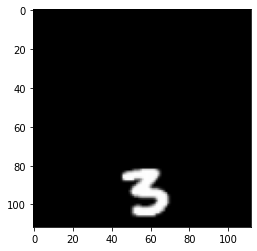

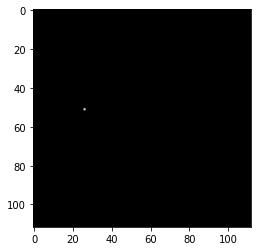

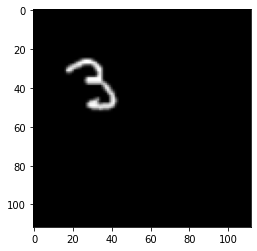

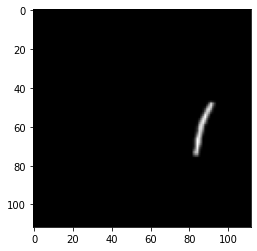

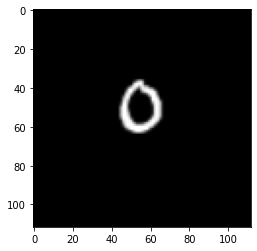

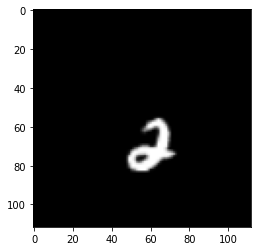

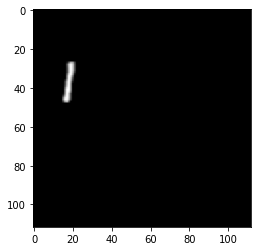

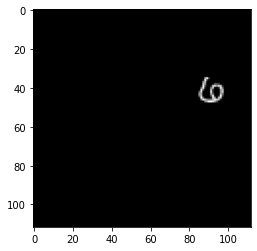

In [15]:
cls, pos = model(x_test)
_, pos = pos.max(1)
_, cls = cls.max(1)

y_test_pos = [y[0]['position'] for y in y_test]
y_test_cls = [y[0]['class'] for y in y_test]

for i in range(len(pos)):
    print(caption_rules.index_to_pos[int(pos[i])], caption_rules.index_to_pos[y_test_pos[i]])
    print(int(cls[i]), y_test_cls[i])
    print('---')
    DataManager.plot_num(x_test[i].reshape(112, 112))

/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:443: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


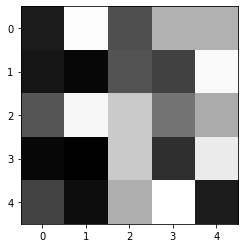

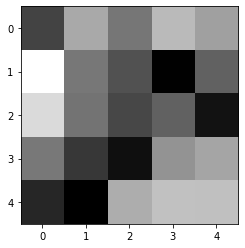

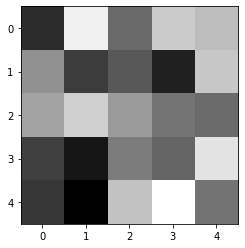

In [20]:
pos_enc = model.pos_enc.w

c1 = pos_enc[0][0].detach().numpy()
c2 = pos_enc[0][1].detach().numpy()

DataManager.plot_num(c1)
DataManager.plot_num(c2)
DataManager.plot_num(c2 + c1)

